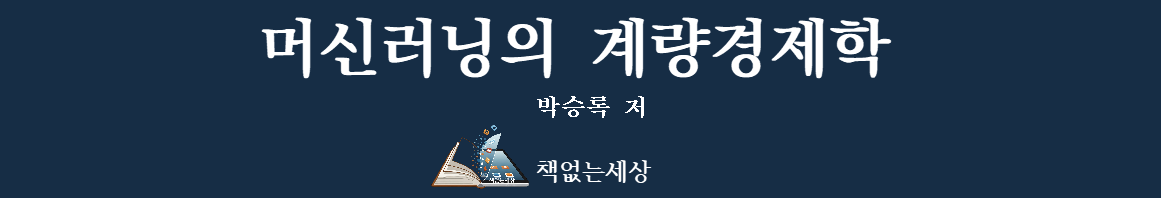

# Part 7: 시계열 분석

## Chapter 1: 단변량 시계열 분석

In [1]:
# 작업공간(working directory)지정  
import os  
os.chdir("E:/JupyterWDirectory/MyStock")
os.getcwd()

'E:\\JupyterWDirectory\\MyStock'

In [2]:
exec(open('E:/JupyterWDirectory/MyStock/Functions/Traditional_Econometrics_Lib.py').read())

In [ ]:
"""
# #####################################################################
# 위의 함수는 아래 다양한 라이브러리와 함수를 한 문장으로 불러오는 방법
# #####################################################################

# 분석에 사용될 라이브러리(Libraries for the Analysis) 불러오기
# Libraries for the Analysis of Traditional Econometrics.py
# 불러오는 방법:  "exec(open('Functions/Traditional_Econometrics_Lib.py').read())"
# #####################################################################

# 만약 특정 라이브러리가 설치되지 않았다는 에러 메시지가 나타날 때는 
# 해당 라이브러리를 설치하여야 함
# 아래 라이브러리를 하나 하나 실행하면서 어떤 라이브러리가 설치되지 않았는지 확인하여도 됨
# #####################################################################
import os
import numpy as np                                       # Numerical calculations
import pandas as pd                                      # Data handling
import math as someAlias
import matplotlib.dates as mdates                        # Turn dates into numbers
import matplotlib.pyplot as plt                          # Lower-level graphics
import patsy as pt
import seaborn as sns
import stargazer.stargazer as sg
import statsmodels.api as sm
import statsmodels.formula.api as smf                    # Econometrics
import statsmodels.stats.api as sms
import statsmodels.stats.diagnostic as dg
import statsmodels.stats.outliers_influence as smo
import linearmodels as lm                                # Panel model, Simultaneous Eq. Model
import scipy.stats as stats                              # Statistics
import random

from scipy.optimize import Bounds
from scipy.optimize import curve_fit                    # Nonlinear regression
from scipy.optimize import minimize
from scipy.stats import norm
from statsmodels.graphics import tsaplots               # Time series
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller          # ADF test
from statsmodels.tsa.stattools import coint             # Cointegration
from statsmodels.tsa.vector_ar.vecm import VECM
from arch import arch_model

import wooldridge as woo
from imfpy.retrievals import dots
import wbdata
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")
"""\

### 1. 기초개념과 시계열 형태의 이해

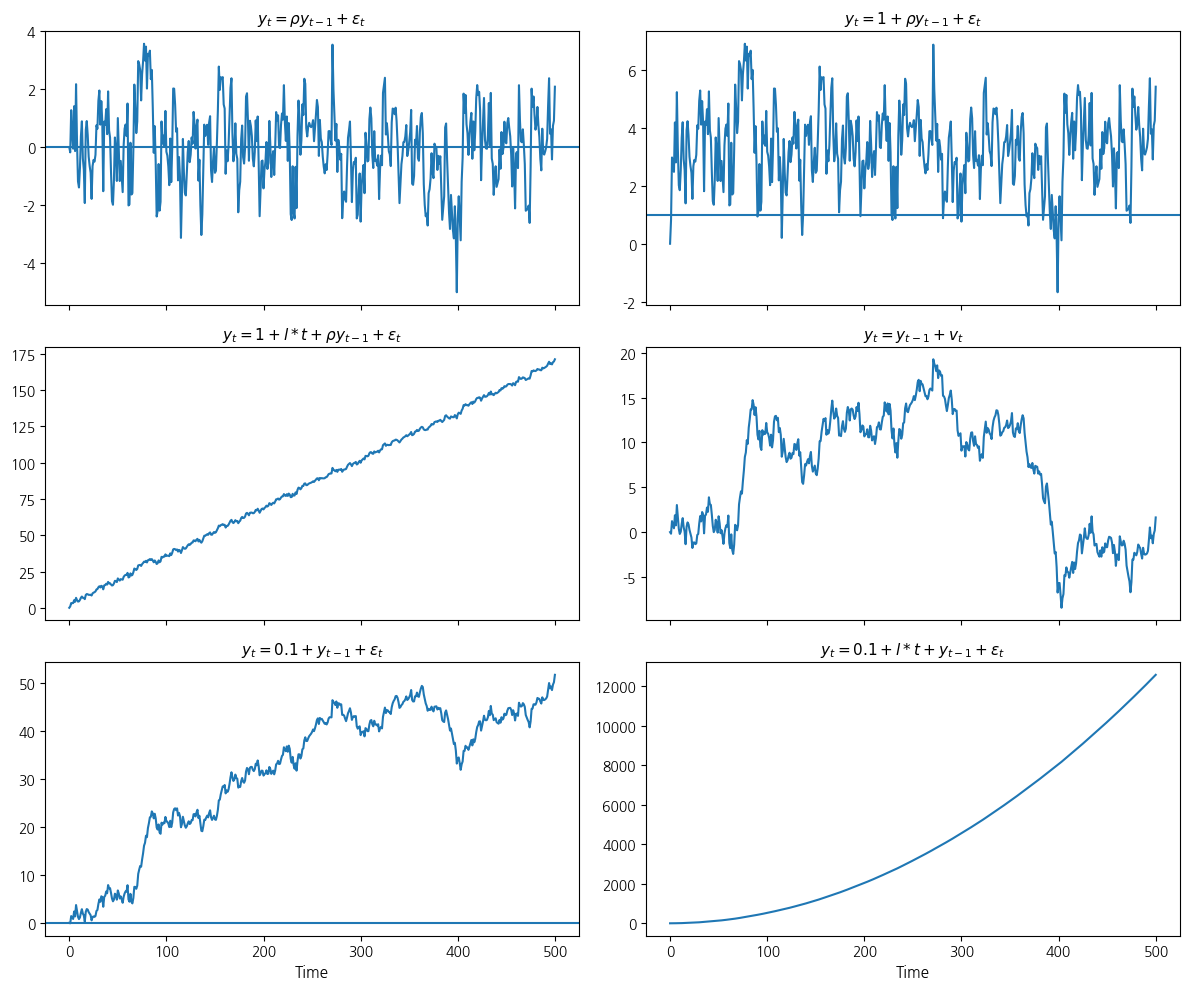

In [3]:
# 인위적인 AR(1) 시계열 자료 생성
N = 501 
x = range(N)
a = 1
l = 0.1
rho = 0.7

# 확률변수 생성을 위한 seed부여
random.seed(123456)
# 백색잡음(white noise) 오차항 생성
e = stats.norm.rvs(0, 1, N)
y = np.zeros(N)

fig, ax = plt.subplots(3, 2, figsize = [12,10], sharex = True)

# 상수항 0인 안정적 시계열(평균=0)
for t in range(1, N):
    y[t]= rho*y[t-1]+e[t]
ax[0,0].plot(y)
ax[0,0].set_title(r'$y_t = \rho y_{t-1}+\varepsilon_t$', fontsize = 11)
ax[0,0].axhline(0, xmin = 0, xmax = N)

# 상수항 1인 안정적 시계열(평균=1)
for t in range(1, N):
    y[t]= a + rho*y[t-1] + e[t]
ax[0,1].plot(y)
ax[0,1].set_title(r'$y_t = 1+\rho y_{t-1}+\varepsilon_t$', fontsize = 11)
ax[0,1].axhline(a, xmin = 0, xmax = N)

# 상수항, 추세항, rho<1의 시계열
for t in range(1, N):
    y[t]= a+l*x[t]+rho*y[t-1]+e[t]
ax[1,0].plot(y)
ax[1,0].set_title(r'$y_t = 1+l*t +\rho y_{t-1}+\varepsilon_t$', fontsize = 11)

# 상수항X, 추세항X, rho=1의 시계열(확률보행)
for t in range(1, N):
    y[t]= y[t-1]+e[t]
ax[1,1].plot(y)
ax[1,1].set_title(r'$y_t = y_{t-1}+v_t$', fontsize = 11)

# 상수항 0.1, 추세항X, rho=1의 시계열(확률보행)
a = 0.1
for t in range(1, N):
    y[t]= a+y[t-1]+e[t]
ax[2,0].plot(y)
ax[2,0].set_title(r'$y_t=0.1+y_{t-1}+\varepsilon_t$', fontsize = 11)
ax[2,0].axhline(0, xmin = 0, xmax = N)
ax[2,0].set_xlabel('Time', fontsize = 11)

# 상수항 0.1, 추세항, rho=1의 시계열(확률보행)
for t in range(1, N):
    y[t]= a+l*x[t]+y[t-1]+e[t]
ax[2,1].plot(y)
ax[2,1].set_title(r'$y_t=0.1+l*t+ y_{t-1}+\varepsilon_t$', fontsize = 11)
ax[2,1].set_xlabel('Time', fontsize = 11) 

fig.tight_layout()
plt.show()


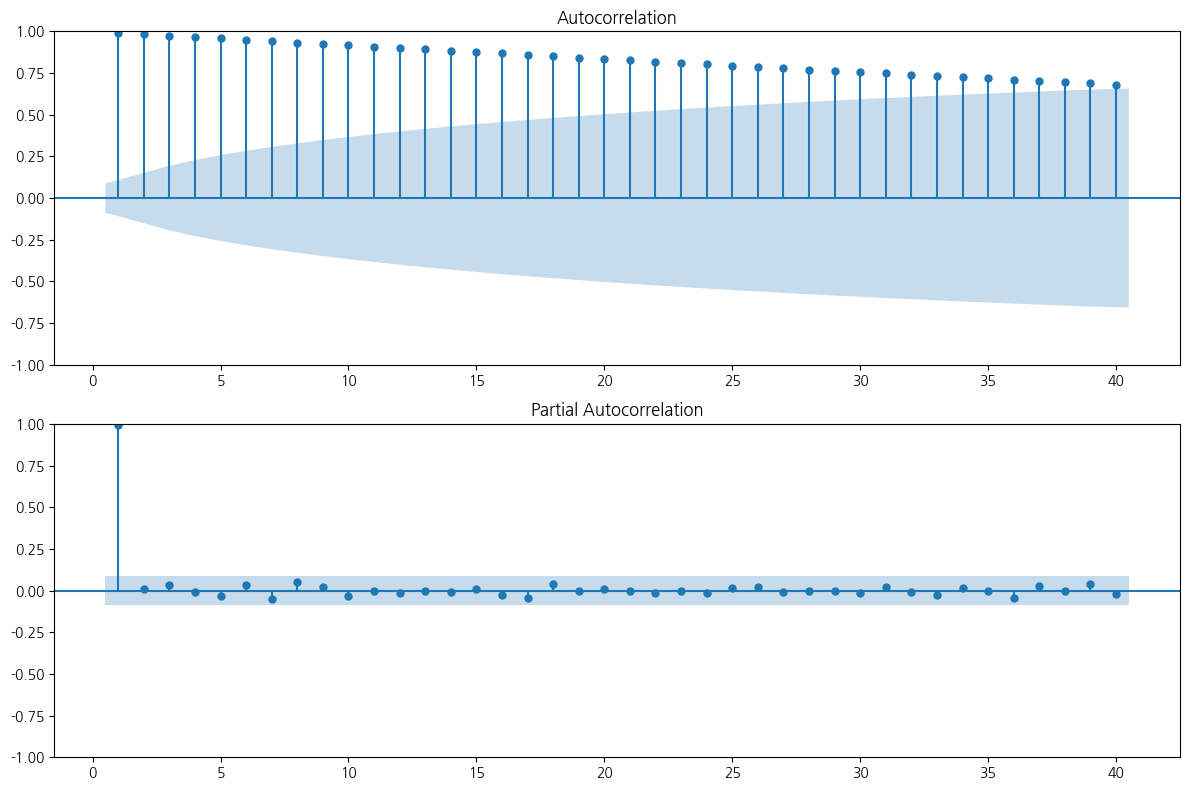

In [4]:
# 상수항 0.1, 추세항X, rho=1의 시계열(확률보행)의 ACF, PACF 그래프 그리기
a = 0.1
for t in range(1, N):
    y[t]= a+y[t-1]+e[t]
    
fig, ax = plt.subplots(2,1,  figsize = (12,8))
plot_acf(y, lags=40, ax=ax[0], zero=False)
plot_pacf(y, lags=40, ax=ax[1], zero=False)  
fig.tight_layout()
plt.show()

## 1) 이동평균법(Moving Average)

In [5]:
# 한국의 거시경제 통계자료 불러오기
# 통계 업데이트 : ecos.bok.or.kr/#/Short/af4c9c
data = pd.read_csv('E:/JupyterWDirectory/Udemy Time Series/Data/Korea_GDP.csv',index_col='Time', parse_dates=True)

new_index = pd.date_range(start='1961-03-31', periods=len(data), freq='Q')
data.index = pd.to_datetime(new_index)
data.index

DatetimeIndex(['1961-03-31', '1961-06-30', '1961-09-30', '1961-12-31',
               '1962-03-31', '1962-06-30', '1962-09-30', '1962-12-31',
               '1963-03-31', '1963-06-30',
               ...
               '2021-09-30', '2021-12-31', '2022-03-31', '2022-06-30',
               '2022-09-30', '2022-12-31', '2023-03-31', '2023-06-30',
               '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', length=252, freq='Q-DEC')

#### 1) 단순이동평균; (2) 지수적 가중 이동평균법

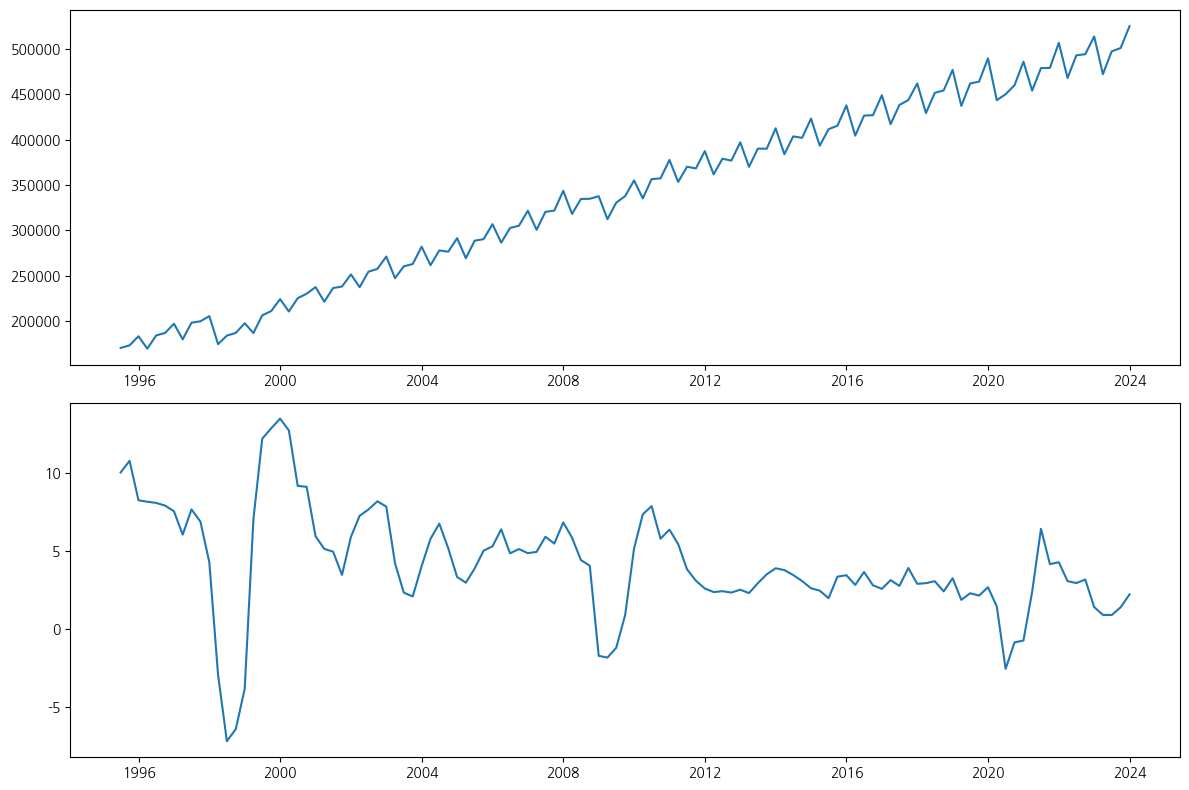

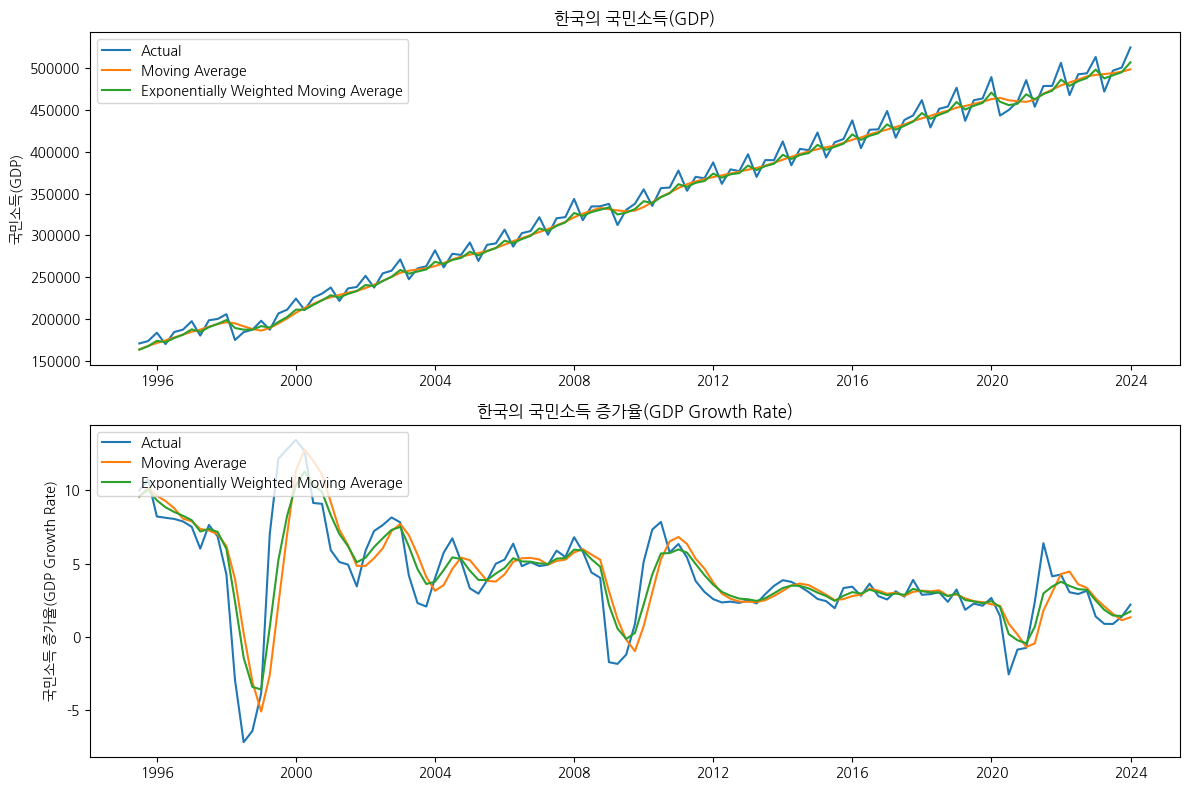

In [6]:
# 증가율 
data['Gr_gdp'] = 100*data['gdp'].pct_change(periods=4)

# 단순 이동평균(SMA)
data['SMA_gdp']    = data['gdp'].rolling(window=4).mean()
data['SMA_Gr_gdp'] = data['Gr_gdp'].rolling(window=4).mean()

# 지수 가중이동평균(EWMA) 
data['EWMA_gdp']    = data['gdp'].ewm(span=4, adjust=False).mean()
data['EWMA_Gr_gdp'] = data['Gr_gdp'].ewm(span=4, adjust=False).mean()
data

df = data.dropna()
df

fig, ax = plt.subplots(2,1, figsize = (12,8))
ax[0].plot(df['gdp'])
ax[1].plot(df['Gr_gdp'])
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(2,1, figsize = (12,8))
ax[0].plot(df['gdp'], label='Actual')
ax[0].plot(df['SMA_gdp'], label='Moving Average')
ax[0].plot(df['EWMA_gdp'], label='Exponentially Weighted Moving Average')
ax[0].set_title('한국의 국민소득(GDP)')
ax[0].set_ylabel('국민소득(GDP)')
ax[0].legend(loc='upper left')

ax[1].plot(df['Gr_gdp'], label='Actual')
ax[1].plot(df['SMA_Gr_gdp'], label='Moving Average')
ax[1].plot(df['EWMA_Gr_gdp'], label='Exponentially Weighted Moving Average')
ax[1].set_title('한국의 국민소득 증가율(GDP Growth Rate)')
ax[1].set_ylabel('국민소득 증가율(GDP Growth Rate)')
ax[1].legend(loc='upper left')
fig.tight_layout()
plt.show();


#### 2) Hodrick-Prescott filter

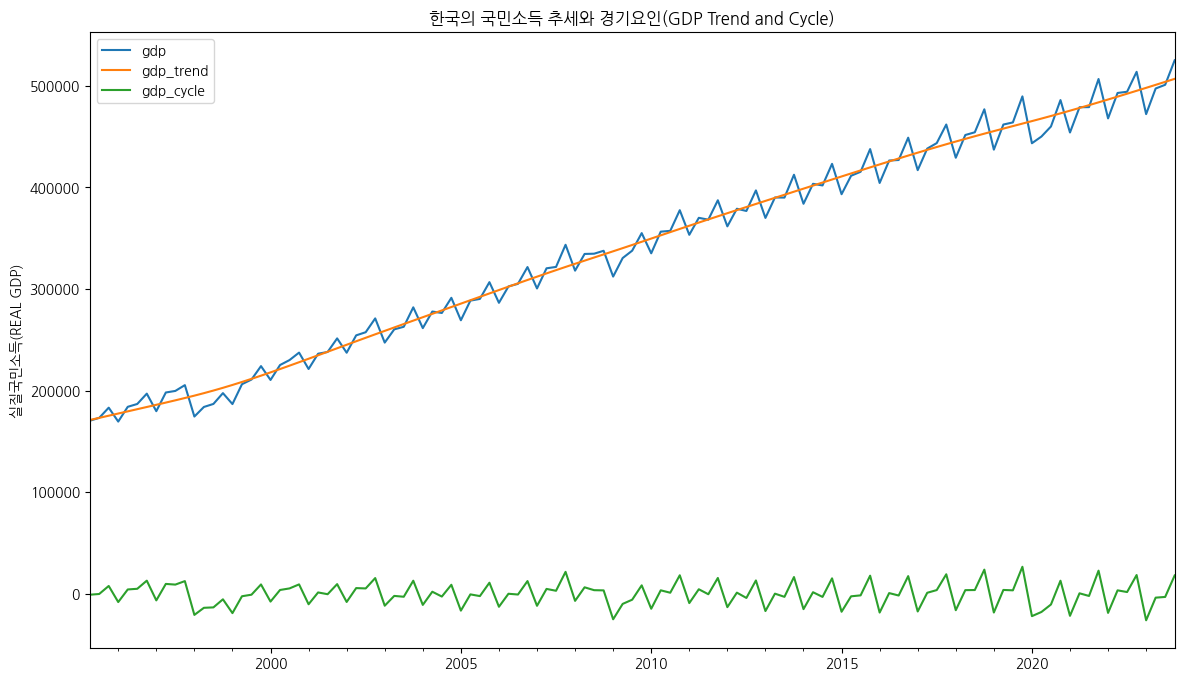

In [7]:
# Hodrick-Prescott filter
# 원계열에 대한 HP
gdp_cycle, gdp_trend = hpfilter(df['gdp'], lamb=1600)
df['gdp_trend'] = gdp_trend
df['gdp_cycle'] = gdp_cycle

ax =df[['gdp', 'gdp_trend', 'gdp_cycle']].plot(figsize=(14,8))
ax.autoscale(axis='x',tight=True)
ax.set_ylabel('실질국민소득(REAL GDP)')
ax.set_title('한국의 국민소득 추세와 경기요인(GDP Trend and Cycle)')
plt.show();


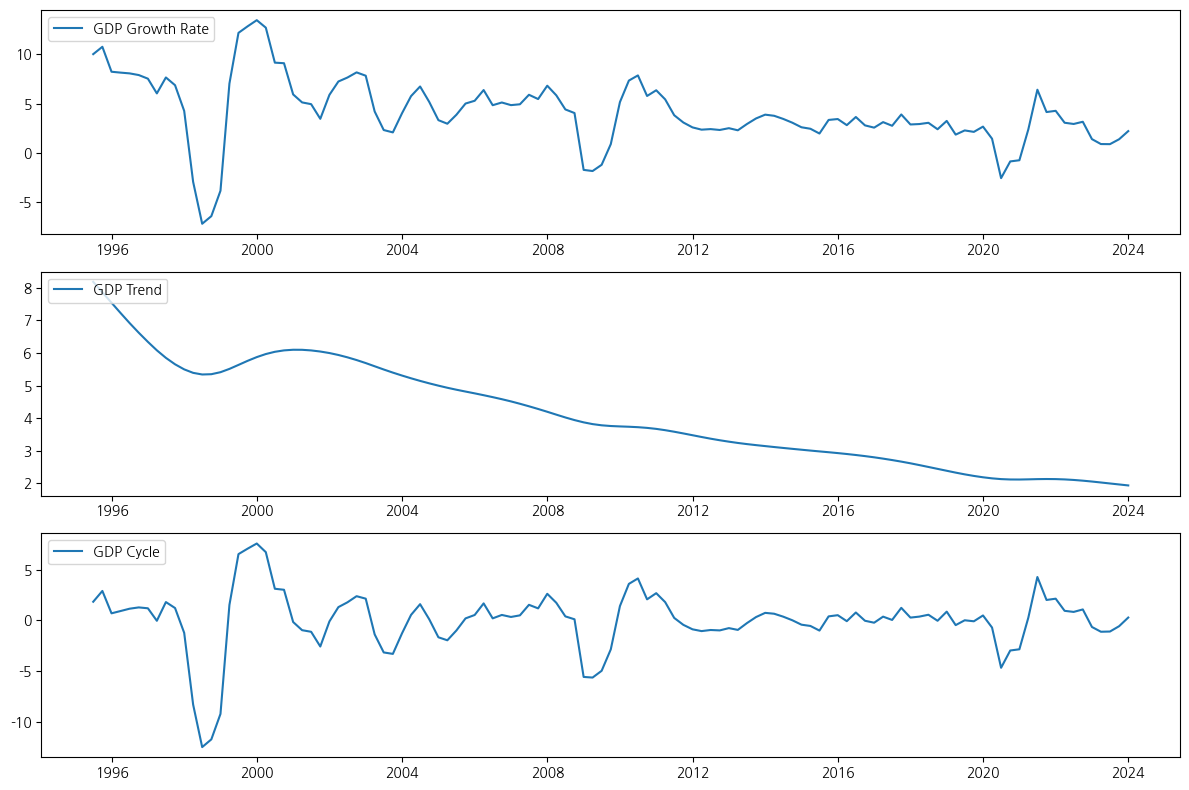

In [8]:
# 증가율지표에 대한 HP
Gr_gdp_cycle, Gr_gdp_trend = hpfilter(df['Gr_gdp'], lamb=1600)
df['Gr_gdp_trend'] = Gr_gdp_trend
df['Gr_gdp_cycle'] = Gr_gdp_cycle
df
fig, ax = plt.subplots(3,1, figsize = (12,8))
ax[0].plot(df['Gr_gdp'], label='GDP Growth Rate')
ax[0].legend(loc='upper left')
ax[1].plot(df['Gr_gdp_trend'], label='GDP Trend')
ax[1].legend(loc='upper left')
ax[2].plot(df['Gr_gdp_cycle'], label='GDP Cycle')
ax[2].legend(loc='upper left')
fig.tight_layout()
plt.show()


#### 3) 홀트-윈터스의 방법론(Holt-Winters Methods)

<Axes: >

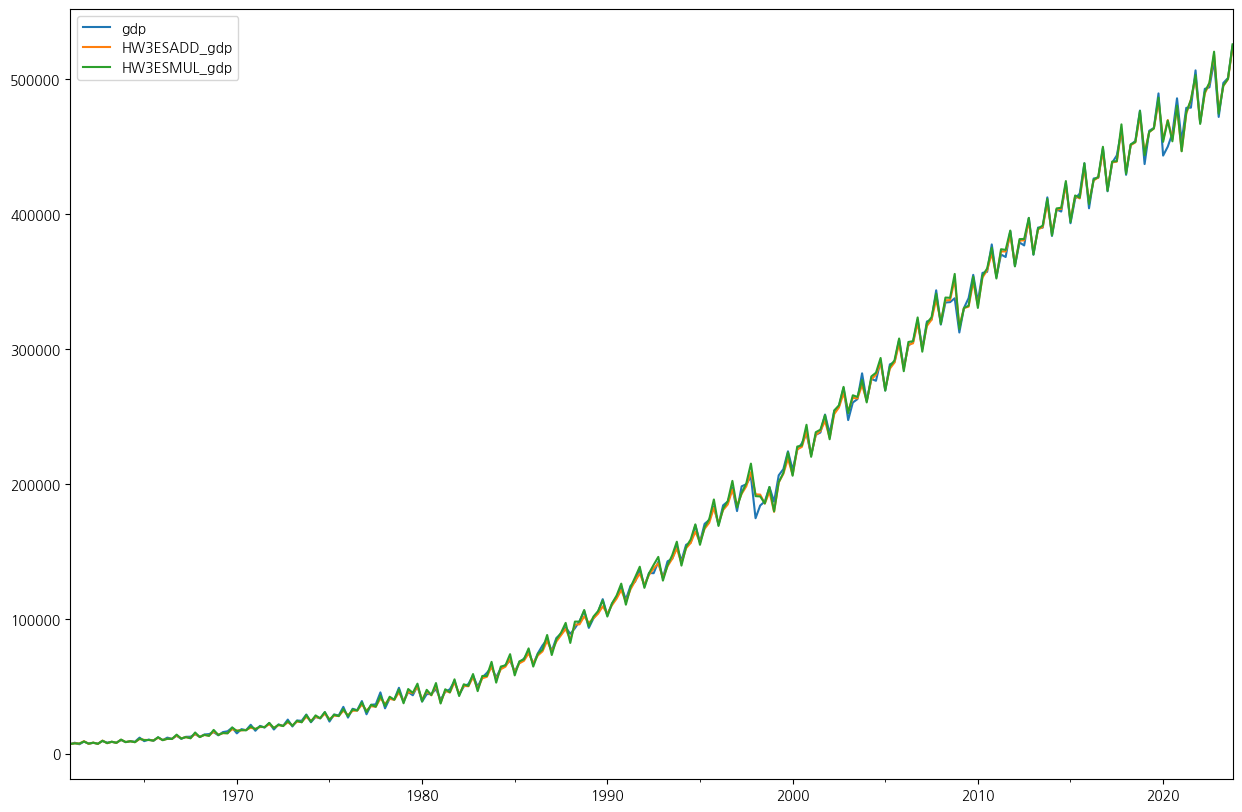

In [9]:
data['HW3ESADD_gdp'] = ExponentialSmoothing(data['gdp'],trend='add',seasonal='add',seasonal_periods=4).fit().fittedvalues
data['HW3ESMUL_gdp'] = ExponentialSmoothing(data['gdp'],trend='mul',seasonal='mul',seasonal_periods=4).fit().fittedvalues
data[['gdp', 'HW3ESADD_gdp', 'HW3ESMUL_gdp']].plot(figsize=(15,10))

In [10]:
# 예측
fitted_model = ExponentialSmoothing(data['gdp'],trend='add',seasonal='add',seasonal_periods=4).fit()
FORCST_gdp  = fitted_model.forecast(12)
FORCST_gdp

2024-03-31    486454.927736
2024-06-30    510046.896765
2024-09-30    513019.261387
2024-12-31    535985.574179
2025-03-31    497575.803541
2025-06-30    521167.772571
2025-09-30    524140.137193
2025-12-31    547106.449984
2026-03-31    508696.679347
2026-06-30    532288.648376
2026-09-30    535261.012998
2026-12-31    558227.325789
Freq: Q-DEC, dtype: float64

#### 4) 계절적 요인의 분해(Seasonal decompositioin) 

                 con       inv      gov        ex        im       gdp  \
1995-06-30  102560.7   69035.8  22783.2   28317.1   43389.3  170434.5   
1995-09-30  103064.2   71677.3  23670.1   27873.7   43374.2  173299.7   
1995-12-31  111567.7   70292.5  25493.6   30800.1   45137.1  183328.4   
1996-03-31  114000.5   59812.5  25863.4   28356.7   46409.9  169643.1   
1996-06-30  110633.5   77633.1  24261.0   30118.6   48537.8  184170.7   
...              ...       ...      ...       ...       ...       ...   
2022-12-31  235677.7  159480.4  89949.2  222599.2  194751.5  513770.2   
2023-03-31  233780.3  132942.8  94700.5  212895.0  198370.1  472155.5   
2023-06-30  229263.8  146189.8  89060.8  217836.1  185450.3  497345.6   
2023-09-30  233387.8  148498.3  82449.8  229952.8  192882.0  500997.0   
2023-12-31  237874.7  155198.8  89118.4  244503.0  201819.6  525122.8   

                   m2    exch    cpi   rat  ...  SMA_Gr_gdp       EWMA_gdp  \
1995-06-30   327647.4   758.1   51.9  14.7  .

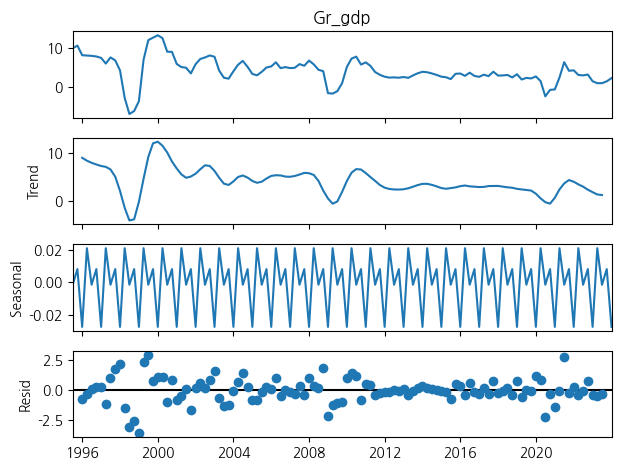

In [11]:
result = seasonal_decompose(df['gdp'], model='multiplicative', period=4) 

#dir(result)
df['Seasonal_gdp'] = result.seasonal
df['Trend_gdp'] = result.trend
df['Resid_gdp'] = result.resid
print(df)


resultr = seasonal_decompose(df['Gr_gdp'], model='addtive', period=4) 

#dir(result)
df['Seasonal_GR_gdp'] = resultr.seasonal
df['Trend_Gr_gdp'] = resultr.trend
df['Resid_Gr_gdp'] = resultr.resid

resultr.plot();

#### 5) X-13 ARIMA 분석

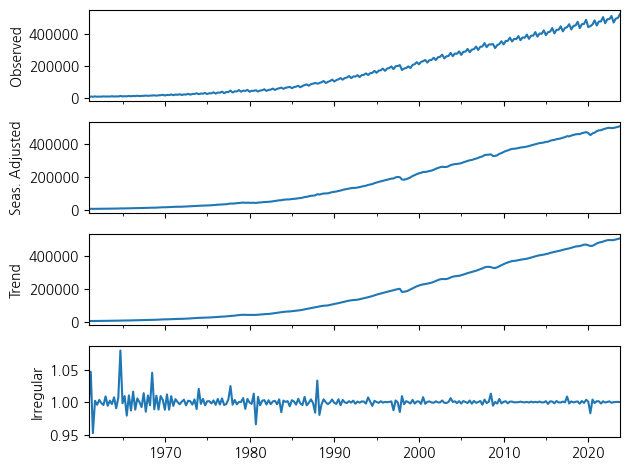

In [12]:
path = 'E:/JupyterWDirectory/MyStock/x13as/'
results_x13 = x13_arima_analysis(endog=data['gdp'], x12path=path, prefer_x13=True)
results_x13.trend
results_x13.seasadj
results_x13.irregular
results_x13.plot()
plt.show()

#### 6) LOESS 방법에 의한 추세, 계절 요인 분해

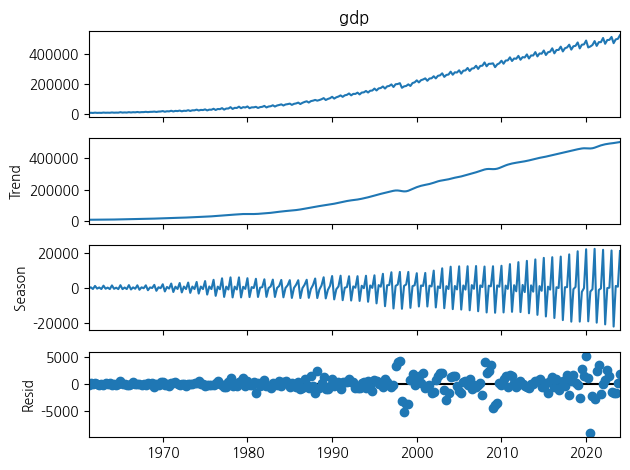

In [24]:
from statsmodels.tsa.seasonal import STL
res = STL(data['gdp'], period=4).fit()
res.plot()
res.trend
res.seasonal
res.resid
plt.show()


### 나. 단위근 검정(unit root test)

#### 2) 부가된 디키 풀러 검정(Augmented Dickey-Fuller)

In [13]:
#from arch.unitroot import Augmented Dickey-Fuller
for i in ['n','c','ct']:    
    adf_tt = ADF(data['gdp'], trend=i, lags=5)  
    print(adf_tt.summary().as_text()) 

   Augmented Dickey-Fuller Results   
Test Statistic                  4.805
P-value                         1.000
Lags                                5
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                  3.427
P-value                         1.000
Lags                                5
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.369
P-value                         0.396
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.00 (1%), -3.4

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.369
P-value                         0.396
Lags                                5
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.00 (1%), -3.43 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     484.0
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          7.11e-137
Time:                        09:52:56   Log-Likelihood:                -2354.9
No. Observations:                 246   AIC:                             4726.
Df Residuals:                     238   BIC:            

<Axes: >

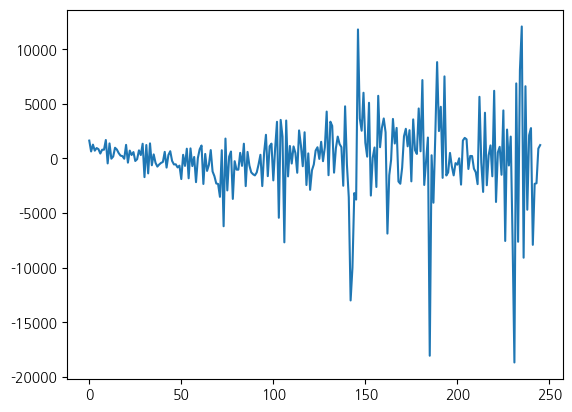

In [14]:
adf_ct = ADF(data['gdp'], trend="ct",lags=5)   
print(adf_ct.summary().as_text())

reg_res = adf_ct.regression
print(reg_res.summary().as_text())
reg_res.resid.plot()

#### 3) 필립스-페론 검정(Phillips-Perron test)

In [15]:
for tt in ['n','c','ct']:    
    pp = PhillipsPerron(data['gdp'], trend=tt, test_type='tau')    
    print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                  6.658
P-value                         1.000
Lags                               16
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                  3.252
P-value                         1.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.112
P-value                         0.539
Lags                               16
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.00 (1%), -3.4

#### 4) KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test

In [18]:
print('KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test for gdp')
kpss_test = kpss(data['gdp'])
print(kpss_test)

KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test for gdp
(2.2982696873281214, 0.01, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


In [ ]:
dfout = pd.Series(kpss_test[0:4],index=['KPSS test statistic','p-value','# lags used','critical value'])
for key,val in kpss_test[3].items():
    dfout[f'critical value ({key})']=val

print(dfout)

(2.2982696873281214, 0.01, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test for gdp
KPSS test statistic                                                2.29827
p-value                                                               0.01
# lags used                                                             10
critical value           {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...
critical value (10%)                                                 0.347
critical value (5%)                                                  0.463
critical value (2.5%)                                                0.574
critical value (1%)                                                  0.739
dtype: object


### 나. 그랜져의 인과성 검정(Granger Causality Tests)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1824  , p=0.2779  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1968  , p=0.2740  , df=1
likelihood ratio test: chi2=1.1939  , p=0.2745  , df=1
parameter F test:         F=1.1824  , p=0.2779  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1015  , p=0.1245  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.2891  , p=0.1171  , df=2
likelihood ratio test: chi2=4.2526  , p=0.1193  , df=2
parameter F test:         F=2.1015  , p=0.1245  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.0523 , p=0.0000  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=46.4686 , p=0.0000  , df=3
likelihood ratio test: chi2=42.5924 , p=0.0000  , df=3
parameter F test:         F=15.0523 , p=0.0000  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=11.6197 , p=0.0000  

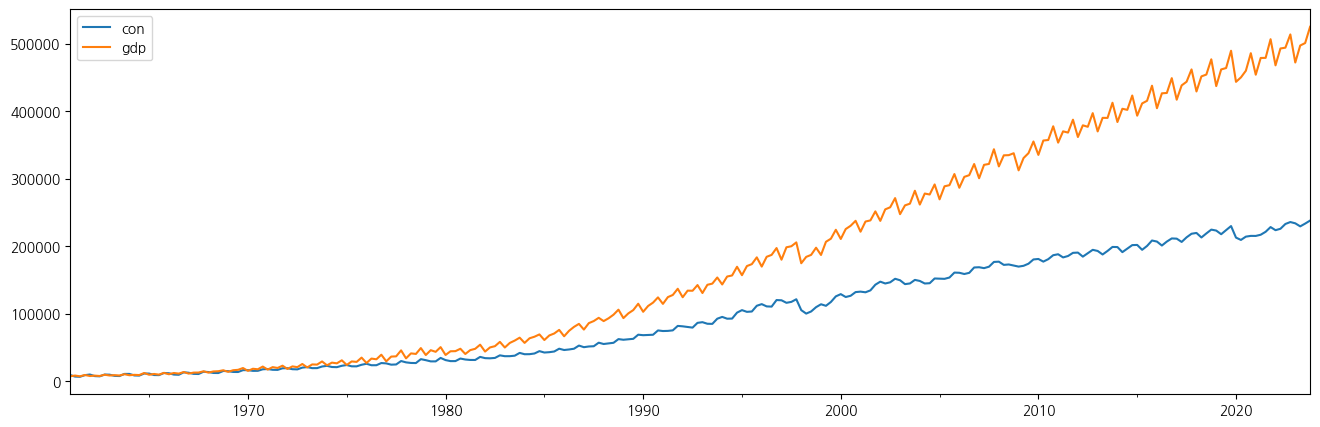

In [19]:
data[['con','gdp']].plot(figsize=(16,5));
data['gdp_L1'] = data['gdp'].shift(1) 
grangercausalitytests(data[['con','gdp_L1']].dropna(),maxlag=4);

## 4. 시계열 모형의 예측 정확성 지표

19672.501081416678 422130616.3315963 20545.817489980687


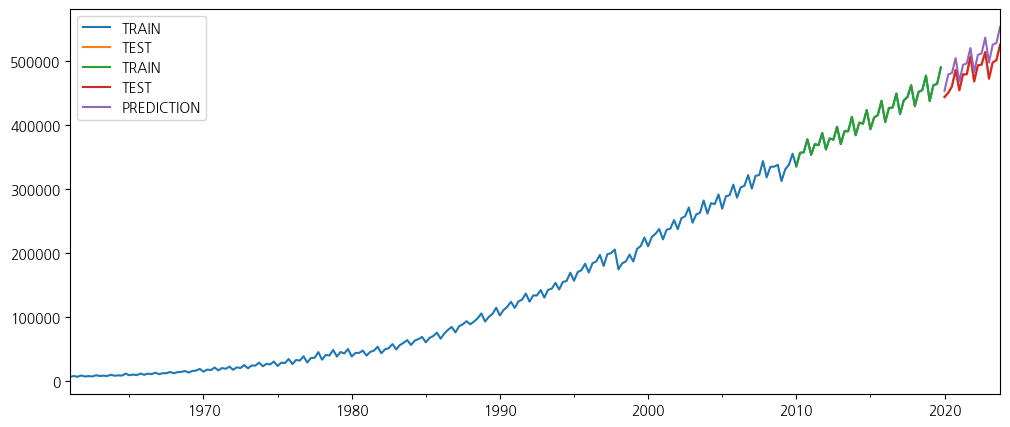

In [20]:
# 데이터세트를 train set과 test set으로 나누기 
train_data = data.loc[:'2020-1-31']
test_data = data.loc['2020-1-31':]

# 모형 추정
fitted_model = ExponentialSmoothing(train_data['gdp'],trend='mul',seasonal='mul',seasonal_periods=4).fit()

# 예측
test_predictions = fitted_model.forecast(16)

# 도표 그리기
train_data['gdp'].plot(legend=True,label='TRAIN')
test_data['gdp'].plot(legend=True,label='TEST',figsize=(12,5));

# 도표의 X축 범위 지정한 그래프
train_data['gdp'].loc['2010-03-31':].plot(legend=True,label='TRAIN')
test_data['gdp'].loc['2010-03-31':].plot(legend=True,label='TEST',figsize=(12,5))
test_predictions.plot(legend=True,label='PREDICTION');

# 예측의 정확성 평가를 위한 통계량
mae = meanabs(test_data['gdp'],test_predictions)
mse = mse(test_data['gdp'],test_predictions)
rmse = rmse(test_data['gdp'],test_predictions)
print(mae, mse, rmse)

## 5. 시계열 자료의 구조변화
### 가. 차오 테스트

In [21]:
# 한국의 거시경제 통계 자료 불러오기
data = pd.read_csv('Data/Korea_GDP.csv',index_col='Time', parse_dates=True)
new_index = pd.date_range(start='1961-03-31', periods=len(data), freq='Q')
data.index = pd.to_datetime(new_index)
data.index
# 퍼센트 변화 계산
y = data['con'].pct_change(4)*100
X = data['gdp'].pct_change(4)*100
X = sm.add_constant(X)

y = y.dropna(axis=0)
X = X.dropna(axis=0)

# Chow Test 
import scipy.stats as st
n = X.shape[0]
k = X.shape[1]

# 제약된 모형(모든 샘플)과 제약없는 모형(구조변화 반영)
model = sm.OLS(y, X).fit()
SSR = model.ssr
model1 = sm.OLS(y[:"1997-12-31"], X[:"1997-12-31"]).fit()
SSR1 = model1.ssr
model2 = sm.OLS(y["1998-03-31":], X["1998-03-31":]).fit()
SSR2 = model2.ssr

# Chow test를 위한 F-통계량
chow = ((SSR-(SSR1+SSR2))/ k) / ((SSR1+SSR2)/(n-2*k)) 
p_value = 1-st.f.cdf(chow, k, n-2*k)

print('F-statistics: ', np.round(chow, 4))
print('p_value: ', np.round(p_value, 4))
print(n)

# Chow test 전제조건 검정을 위한 F-통계량
n1 = X[:"1997-12-31"].shape[0]
n2 = X["1998-03-31":].shape[0]

# 동분산 확인을 위한 F-통계량
homo = SSR1/SSR2 
p_value = 1-st.f.cdf(homo, n1-k, n2-k)
print('F-statistics: ', np.round(homo, 4))
print('p_value: ', np.round(p_value, 4))


F-statistics:  74.8899
p_value:  0.0
248
F-statistics:  1.9919
p_value:  0.0001


In [22]:
# 날짜변수
dates = pd.date_range(start='1961-01-31', periods=len(y), freq='Q')
chow = 1 
periods = 0

for i in range(k+1, n-(k+1)): 
    model = sm.OLS(y, X).fit()
    SCR = model.ssr
    model1 = sm.OLS(y[:i], X[:i]).fit()
    SCR1 = model1.ssr
    model2 = sm.OLS(y[i:], X[i:]).fit()
    SCR2 = model2.ssr
    chow_i = ((SCR - (SCR1 + SCR2)) / k) / ((SCR1 + SCR2) / (n - 2 * k))

    if chow_i > chow: 
        periods = dates[i]  
        chow = chow_i
        p_value = 1 - st.f.cdf(chow_i, k, n - 2 * k)
print('Break period: ', periods.strftime('%Y-%m-%d')) 
print('F-statistics: ', np.round(chow, 4)) 
print('p-value: ', np.round(p_value, 4))

Break period:  1993-06-30
F-statistics:  83.795
p-value:  0.0


### 나. 고전적 회귀모형을 이용한 CUSUM 및 Hansen Test

                            OLS Regression Results                            
Dep. Variable:                    con   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.074e+04
Date:                Wed, 23 Jul 2025   Prob (F-statistic):          1.60e-242
Time:                        10:01:53   Log-Likelihood:                -2631.6
No. Observations:                 252   AIC:                             5267.
Df Residuals:                     250   BIC:                             5274.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.249e+04    792.895     15.758      0.0

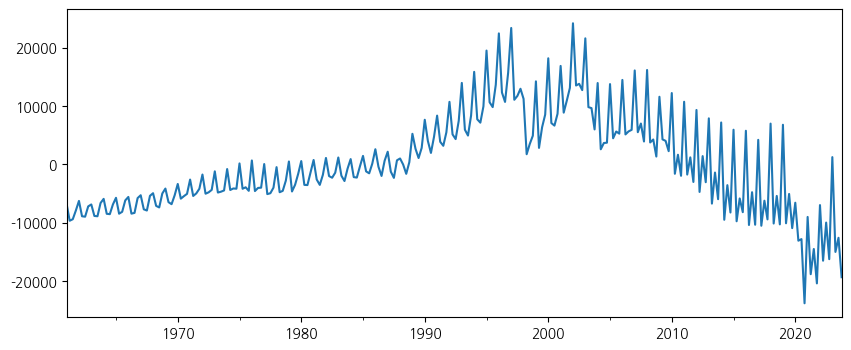

In [23]:
y = data['con']
X = data['gdp']
X = sm.add_constant(X)

endog = pd.concat([y, X], axis=1)
# OLS 추정
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

# 잔차 그림
results.resid.plot(figsize=(10,4))

# 잔차에 대한 Cusum test
cusum_test = sm.stats.diagnostic.breaks_cusumolsresid(results.resid)
print(cusum_test)

# 잔차에 대한 Hansen test
est_statistic = sm.stats.diagnostic.breaks_hansen(results)
print(est_statistic)

### 다. 축차 회귀모형을 이용한 CUSUM Test

                           Statespace Model Results                           
Dep. Variable:                    con   No. Observations:                  252
Model:                    RecursiveLS   Log Likelihood               -2631.033
Date:                Wed, 23 Jul 2025   R-squared:                       0.988
Time:                        10:02:31   AIC                           5266.066
Sample:                    03-31-1961   BIC                           5273.125
                         - 12-31-2023   HQIC                          5268.906
Covariance Type:            nonrobust   Scale                     69405589.735
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.249e+04    792.895     15.758      0.000    1.09e+04     1.4e+04
gdp            0.4661      0.003    144.003      0.000       0.460       0.472
Ljung-Box (L1) (Q):                  67.11   Jarque-

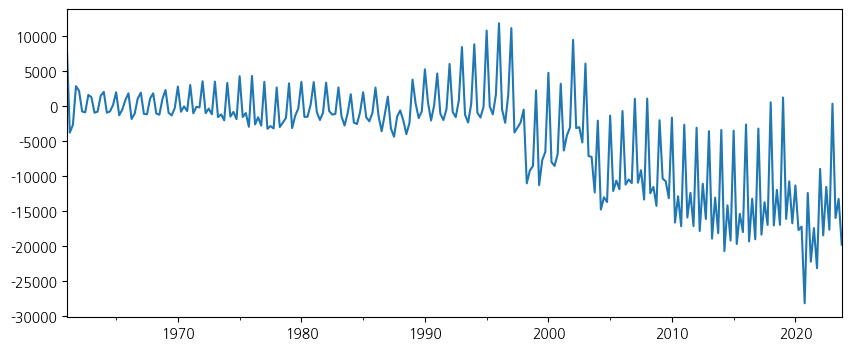

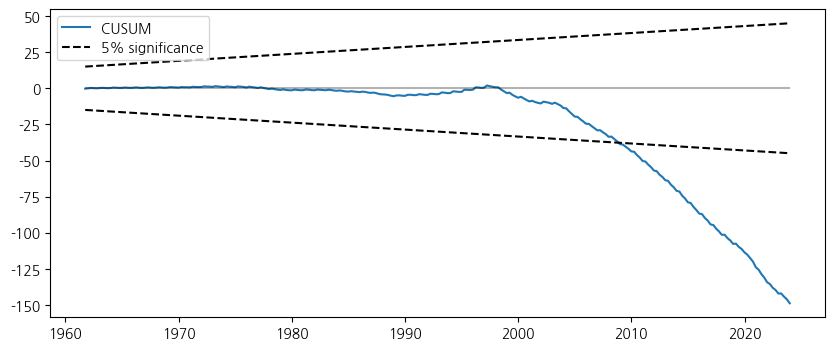

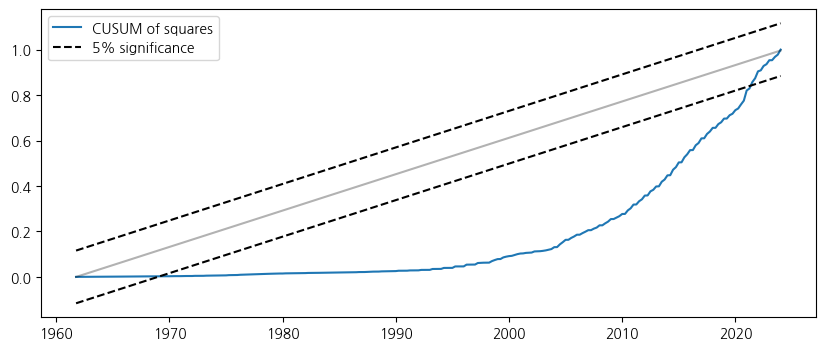

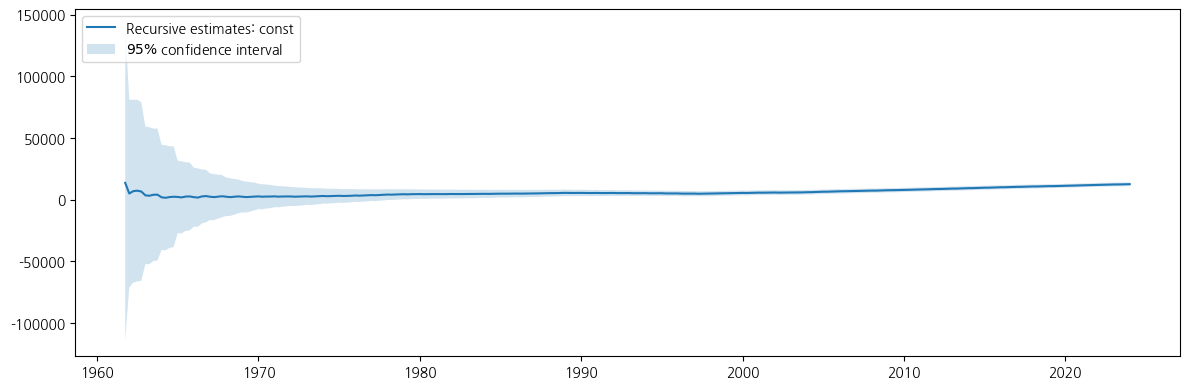

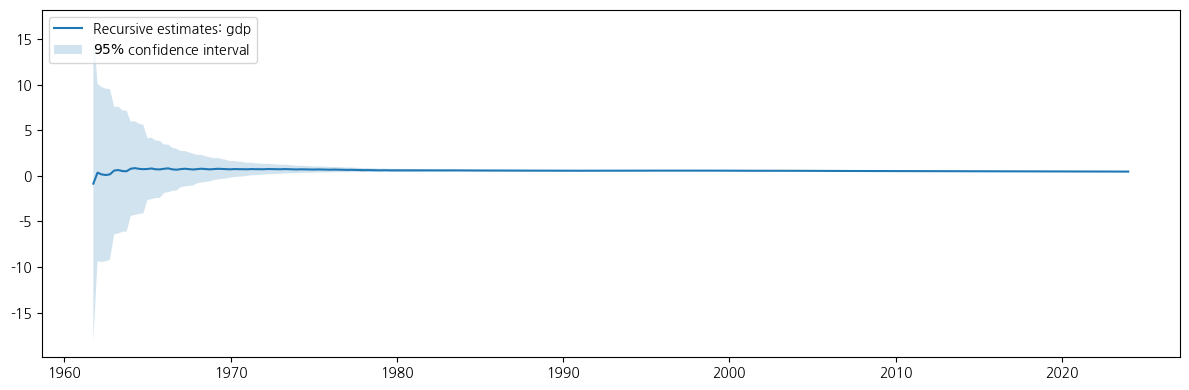

In [24]:
# 축차형 모형의 추정
results2 = sm.RecursiveLS(y,X).fit()
print(results2.summary())
results2.resid.plot(figsize=(10,4))
results2.plot_cusum(figsize=(10,4))
results2.plot_cusum_squares(figsize=(10,4))
plt.show()

for i in range(0, X.shape[1]):
    results2.plot_recursive_coefficient(i, alpha=0.05, figsize=(12,4))
